# ***Outliers and Special Events***

This chapter will cover the following topics:

* Correcting outliers that cause seasonality swings
* Correcting outliers that cause wide uncertainty intervals
* Detecting outliers automatically
* Modeling outliers as special events

## *Correcting outliers that cause seasonality swings*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

from prophet.plot import add_changepoints_to_plot


# National Geographic instagram 'like' data which has some outliers
df = pd.read_csv('../data/instagram_natgeo.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.columns = ['ds', 'y']

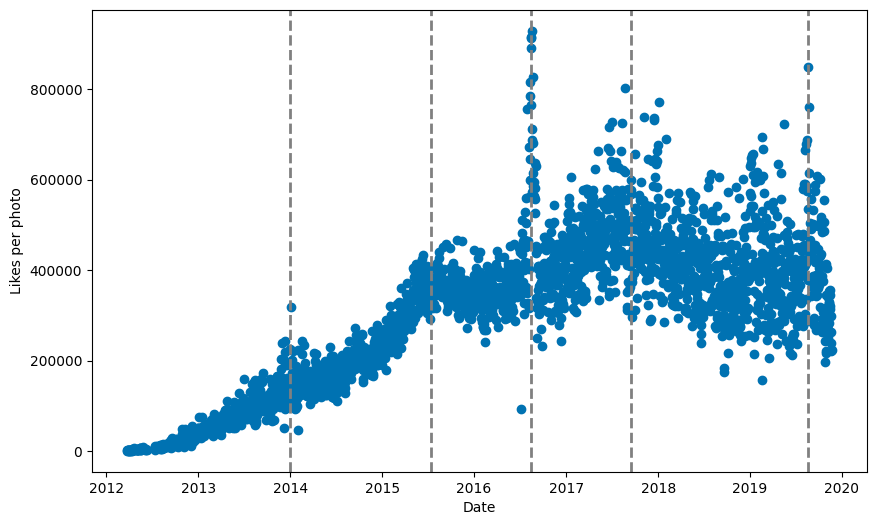

'\nThe second line from the left indicates a radical trend change in the summer of 2015 but the other four lines indicate outliers\n\nData and outlier explanation\nhttps://learning.oreilly.com/library/view/forecasting-time-series/9781800568532/B16867_09_Final_JC_ePub.xhtml#:-:text=Each%20dashed%20vertical%20line\n'

In [2]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['y'], c='#0072B2')
plt.ticklabel_format(style='plain', axis='y')
plt.axvline(pd.to_datetime('2014-01-01'), c='gray', ls='--', lw=2)
plt.axvline(pd.to_datetime('2015-07-15'), c='gray', ls='--', lw=2)
plt.axvline(pd.to_datetime('2016-08-15'), c='gray', ls='--', lw=2)
plt.axvline(pd.to_datetime('2017-09-15'), c='gray', ls='--', lw=2)
plt.axvline(pd.to_datetime('2019-08-20'), c='gray', ls='--', lw=2)
plt.xlabel('Date')
plt.ylabel('Likes per photo')
plt.show()


'''
The second line from the left indicates a radical trend change in the summer of 2015 but the other four lines indicate outliers

Data and outlier explanation
https://learning.oreilly.com/library/view/forecasting-time-series/9781800568532/B16867_09_Final_JC_ePub.xhtml#:-:text=Each%20dashed%20vertical%20line
'''


08:14:48 - cmdstanpy - INFO - Chain [1] start processing
08:14:48 - cmdstanpy - INFO - Chain [1] done processing


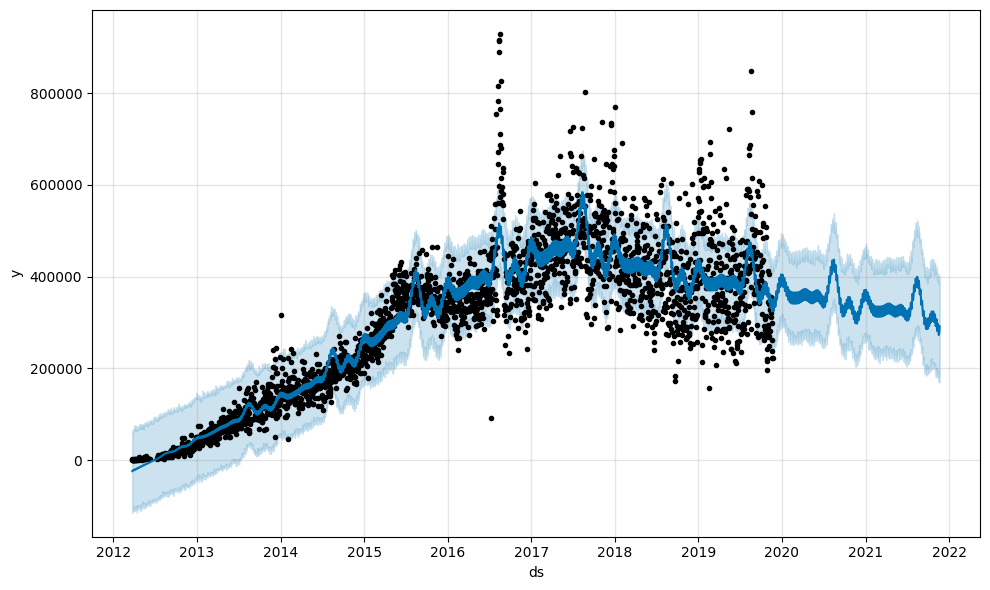

In [3]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=6)
model.fit(df)
future = model.make_future_dataframe(periods=365 * 2)
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

In [4]:
from prophet.plot import plot_plotly

fig = plot_plotly(model, forecast)
fig.show()

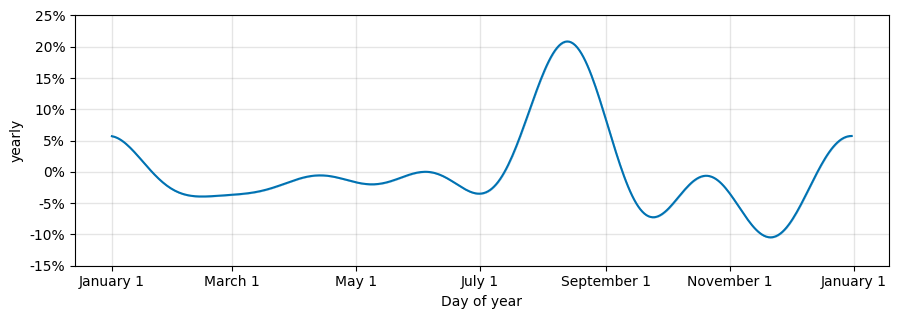

In [5]:
## plot only yearly seasonality
from prophet.plot import plot_yearly

plot_yearly(model, figsize=(10.5, 3.25))
plt.show()

# see 2016 outlier effect in August

In [6]:
# Remove 2016 August outliers
df2 = df[(df['ds'] < '2016-07-29') | (df['ds'] > '2016-09-01')]

08:35:48 - cmdstanpy - INFO - Chain [1] start processing
08:35:48 - cmdstanpy - INFO - Chain [1] done processing


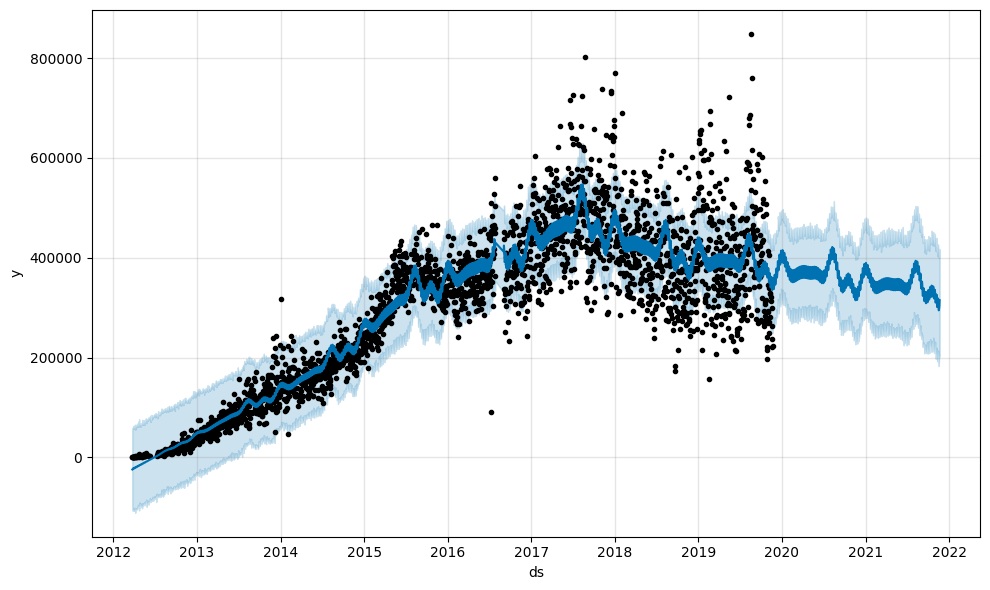

In [7]:
# Re train
# See, 2016 August data gap

model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=6)
model.fit(df2)
future = model.make_future_dataframe(periods=365 * 2)
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

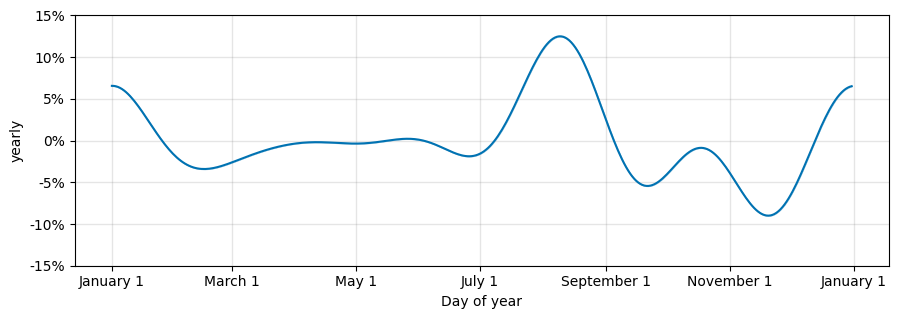

In [8]:
# 20% -> 12% in August

plot_yearly(model, figsize=(10.5, 3.25))
plt.show()

## *Correcting outliers that cuase wide uncertainty intervals*

In [9]:
## add error data to simulate this problem

df3 = df.copy()
df3.loc[df3['ds'].dt.year == 2016, 'y'] = 100000

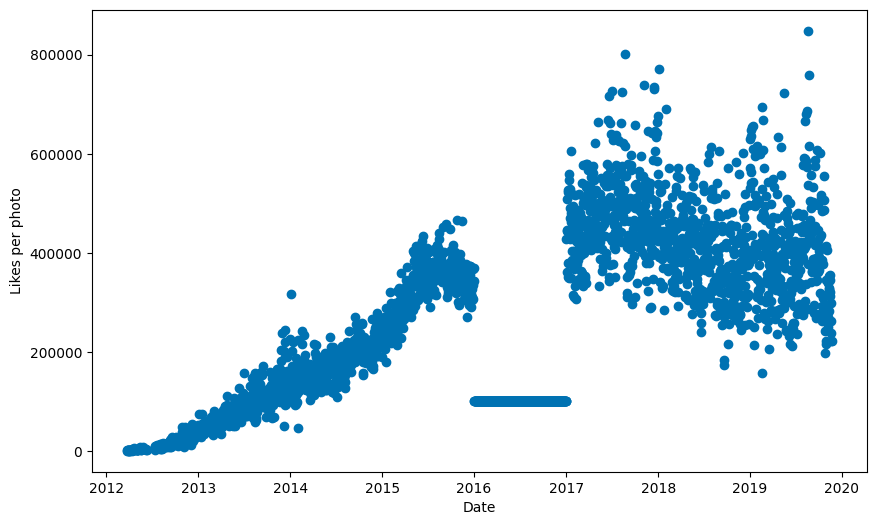

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df3['ds'], y=df3['y'], c='#0072B2')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Date')
plt.ylabel('Likes per photo')
plt.show()

10:17:19 - cmdstanpy - INFO - Chain [1] start processing
10:17:19 - cmdstanpy - INFO - Chain [1] done processing


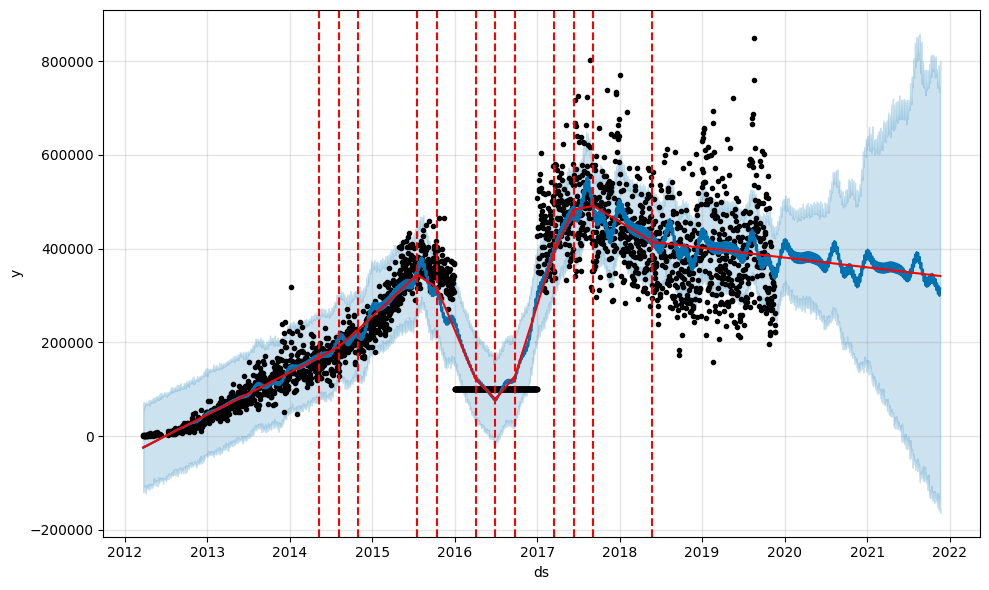

In [11]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=6)
model.fit(df3)
future = model.make_future_dataframe(periods=365 * 2)
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

# Future uncertainty explodes

In [12]:
# simpliy remove bad data , None
# no difference to our trend and seasonalities

df3.loc[df3['ds'].dt.year == 2016, 'y'] = None

10:26:54 - cmdstanpy - INFO - Chain [1] start processing
10:26:54 - cmdstanpy - INFO - Chain [1] done processing


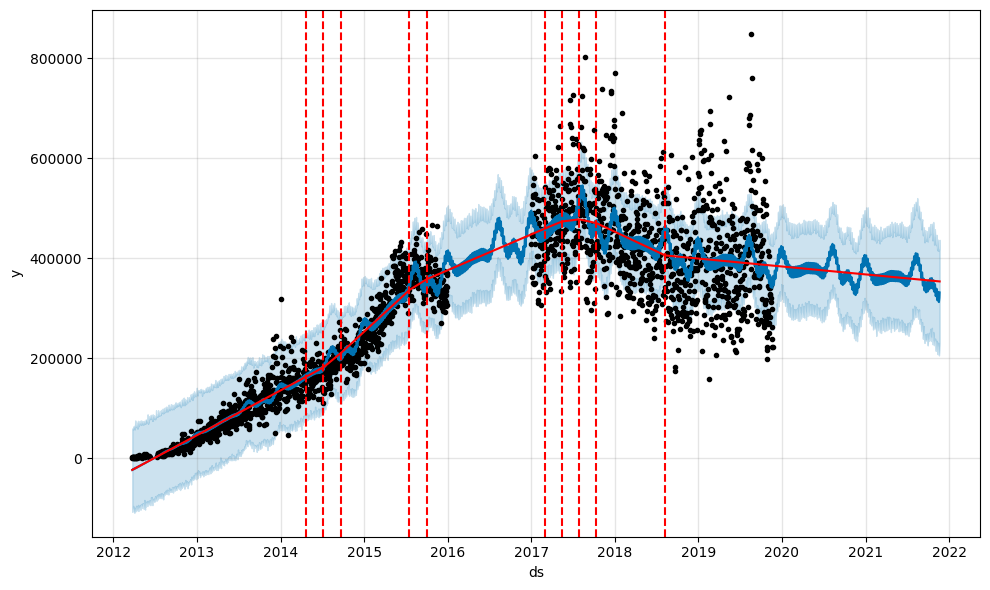

In [13]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=6)
model.fit(df3)
future = model.make_future_dataframe(periods=365 * 2)
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()


# see trend in 2016 and future uncertainty

## *Detecting Outliers Automatically*

### *Winsorization(Clipping) , Trimming*

In [17]:

from scipy import stats
import numpy as np

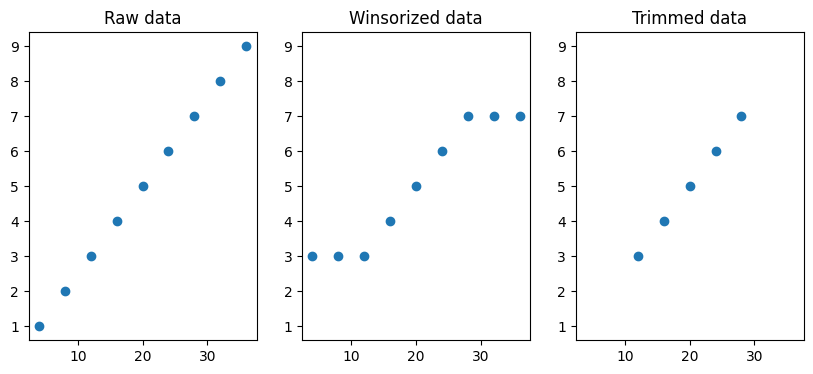

In [18]:
from matplotlib.ticker import MaxNLocator

x = np.array( [4 * val for val in [1, 2, 3, 4, 5, 6, 7, 8, 9]] )
y = np.array( [.25 * val for val in x] )

fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(x, y)
ax1.title.set_text('Raw data')

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(x, stats.mstats.winsorize(y, .25))
ax2.title.set_text('Winsorized data')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(x[2:-2], y[2:-2])
ax3.title.set_text('Trimmed data')
ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax3.set_xlim(ax1.get_xlim())
ax3.set_ylim(ax1.get_ylim())

plt.show()

In [19]:
# use dropna() before to use winsorize
# lower limit = 0, upper limit = 0.05 ( remove more than upper 95%)

df4 = df.copy().dropna()
df4['y'] = stats.mstats.winsorize(df4['y'], limits=(0, .05), axis=0)

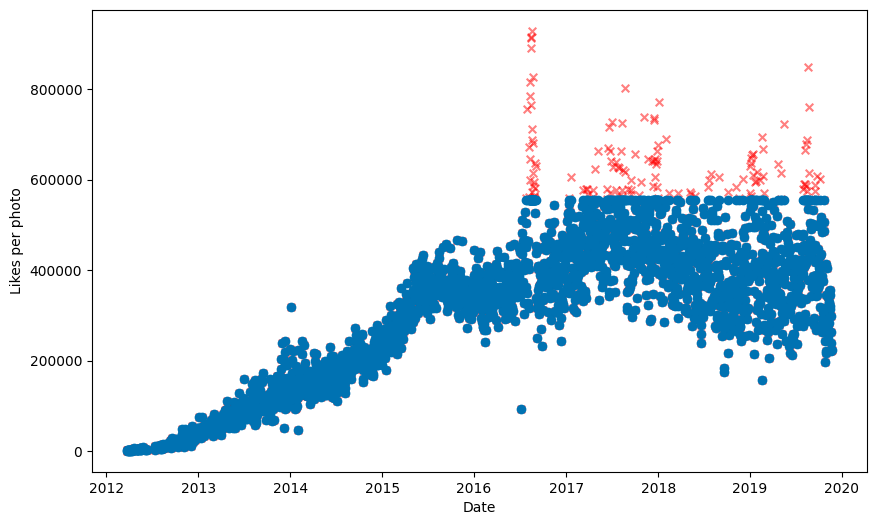

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['y'], c='r', alpha=.5, marker='x', s=30)
plt.scatter(x=df4['ds'], y=df4['y'], c='#0072B2')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Date')
plt.ylabel('Likes per photo')
plt.show()

### *Standard deviation*

In [21]:
df5 = df.copy().dropna()
df5 = df5[(stats.zscore(df5['y']) < 1.65)] # see 1.65, 95%

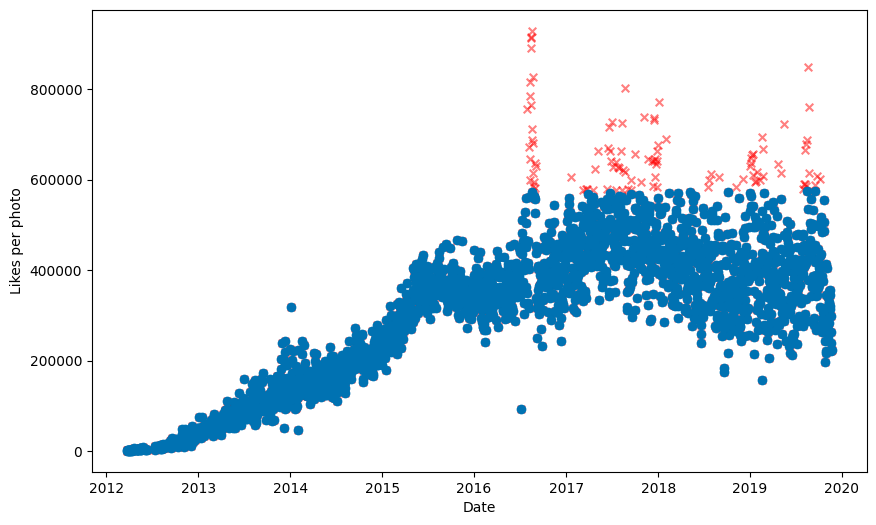

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['y'], c='r', alpha=.5, marker='x', s=30)
plt.scatter(x=df5['ds'], y=df5['y'], c='#0072B2')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Date')
plt.ylabel('Likes per photo')
plt.show()

'''
This method is also a poor fit when the data features a trend. 
Obviously, points lying later in a time series with an upward trend are more likely to be trimmed 
than those lying earlier
'''

### *Moving average*

In [24]:
df6 = df.copy().dropna()

# rolling window , moving average and std_dev
df6['moving_average'] = df6.rolling(window=300,
                                    min_periods=1, # at least 1 datapoint exists
                                    center=True, # to center data in window
                                    on='ds')['y'].mean() # calculate mean of 'y'
df6['std_dev'] = df6.rolling(window=300,
                             min_periods=1,
                             center=True,
                             on='ds')['y'].std()

# set upper , lower limit
df6['lower'] = df6['moving_average'] - 1.65 * df6['std_dev']
df6['upper'] = df6['moving_average'] + 1.65 * df6['std_dev']

df6 = df6[(df6['y'] < df6['upper']) & (df6['y'] > df6['lower'])]

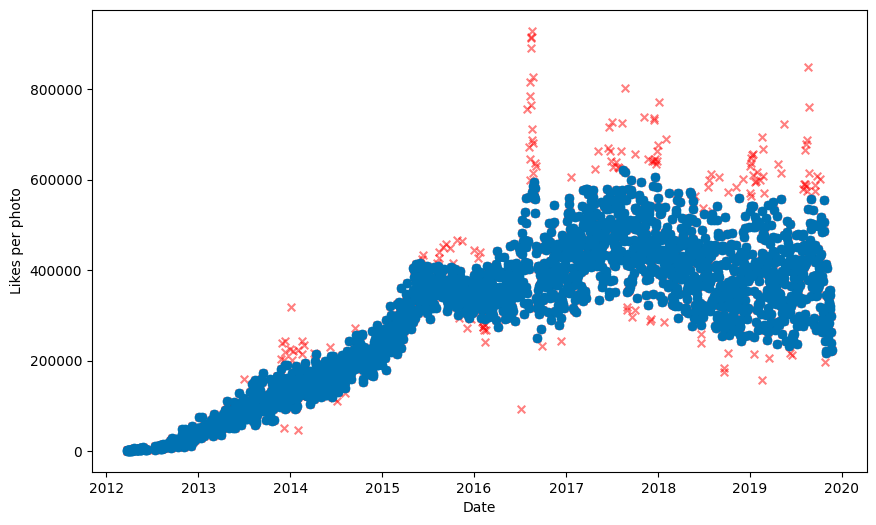

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['y'], c='r', alpha=.5, marker='x', s=30)
plt.scatter(x=df6['ds'], y=df6['y'], c='#0072B2')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Date')
plt.ylabel('Likes per photo')
plt.show()

### *Error standard deviation*

In [26]:
df7 = df.copy().dropna().reset_index()

In [27]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=6,
                seasonality_prior_scale=.01,
                changepoint_prior_scale=.01,
                interval_width=.90)
model.fit(df7)
forecast = model.predict()

12:25:49 - cmdstanpy - INFO - Chain [1] start processing
12:25:50 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
# remove outliers using uncertainty

df8 = df7[(df7['y'] > forecast['yhat_lower']) &
         (df7['y'] < forecast['yhat_upper'])]

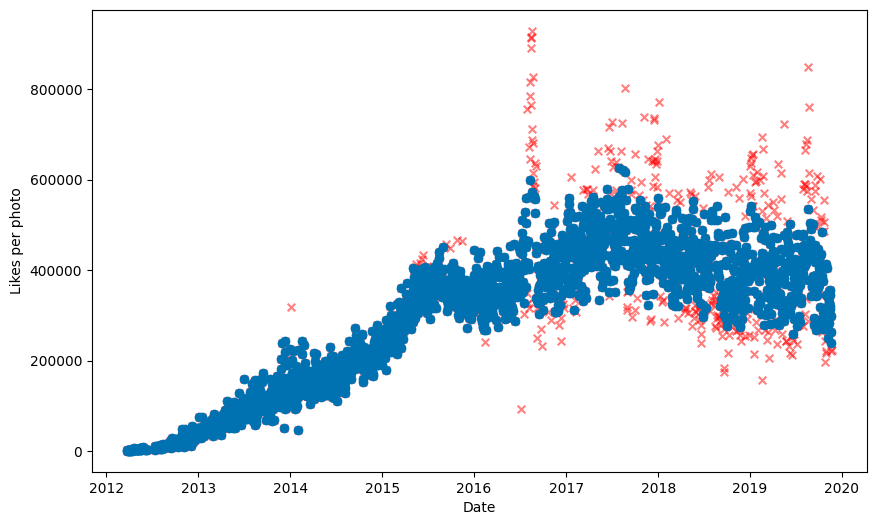

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['y'], c='r', alpha=.5, marker='x', s=30)
plt.scatter(x=df8['ds'], y=df8['y'], c='#0072B2')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Date')
plt.ylabel('Likes per photo')
plt.show()

## *Modeling Outliers as special events*

In [30]:
promo = pd.DataFrame({'holiday': 'Promo event',
                      'ds' : pd.to_datetime(['2016-07-29']),
                      'lower_window': 0,
                      'upper_window': 34})
future_promo = pd.DataFrame({'holiday': 'Promo event',
                      'ds' : pd.to_datetime(['2020-06-01']),
                      'lower_window': 0,
                      'upper_window': 34})

promos = pd.concat([promo, future_promo])

13:48:55 - cmdstanpy - INFO - Chain [1] start processing
13:48:55 - cmdstanpy - INFO - Chain [1] done processing


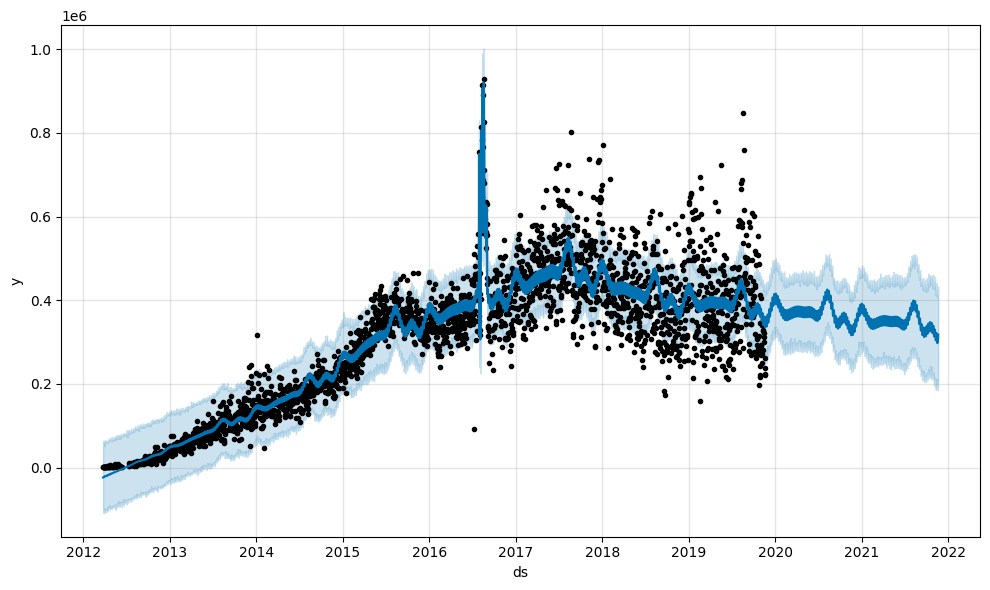

In [31]:
model = Prophet(seasonality_mode='multiplicative',
                holidays=promo, # just promo , w/o future_promo
                yearly_seasonality=6)
model.fit(df)
future = model.make_future_dataframe(periods=365 * 2)
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

13:50:42 - cmdstanpy - INFO - Chain [1] start processing
13:50:42 - cmdstanpy - INFO - Chain [1] done processing


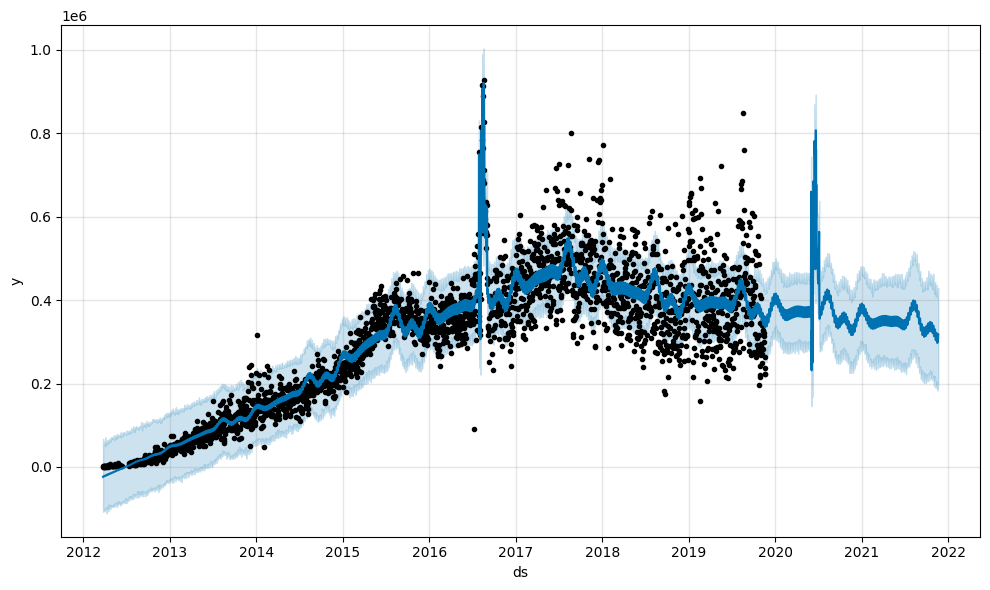

In [32]:
model = Prophet(seasonality_mode='multiplicative',
                holidays=promos, # promo _ future_promo
                yearly_seasonality=6)
model.fit(df)
future = model.make_future_dataframe(periods=365 * 2)
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()